# ARIMA / SARIMAX Modeling — Rossmann Store Sales
**Notebook 03** — ARIMA + SARIMAX with Exogenous Features

| Model | Exog Features | Key difference |
|---|---|---|
| ARIMA(2,1,2) | None | Univariate baseline |
| **SARIMAX(2,1,2)** | **16 features** | **Promo + holidays + Fourier** |

**Plan:** Load → Prepare → ADF → ACF/PACF → Fit ARIMA → Fit SARIMAX → Evaluate → Save

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, os, warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize': (14, 4), 'axes.titlesize': 13})
os.makedirs('../models', exist_ok=True)
os.makedirs('../reports/figures', exist_ok=True)

STORE_ID    = 1
SPLIT_RATIO = 0.80
ORDER       = (2, 1, 2)

EXOG_FEATURES = [
    'Promo', 'SchoolHoliday', 'IsPublicHoliday', 'IsChristmas',
    'IsMonday', 'IsSaturday', 'IsMonthEnd', 'IsQ4',
    'BeforeHoliday', 'AfterHoliday', 'Promo_x_Monday', 'Promo_x_SchoolHol',
    'fourier_weekly_sin_7_1', 'fourier_weekly_cos_7_1',
    'fourier_annual_sin_365_1', 'fourier_annual_cos_365_1',
]
print('Imports done ✅')

Imports done ✅


## 2. Load & Prepare Data

Store 1 : 781 days
Exog features  : 16
Train : 624 | Val : 157


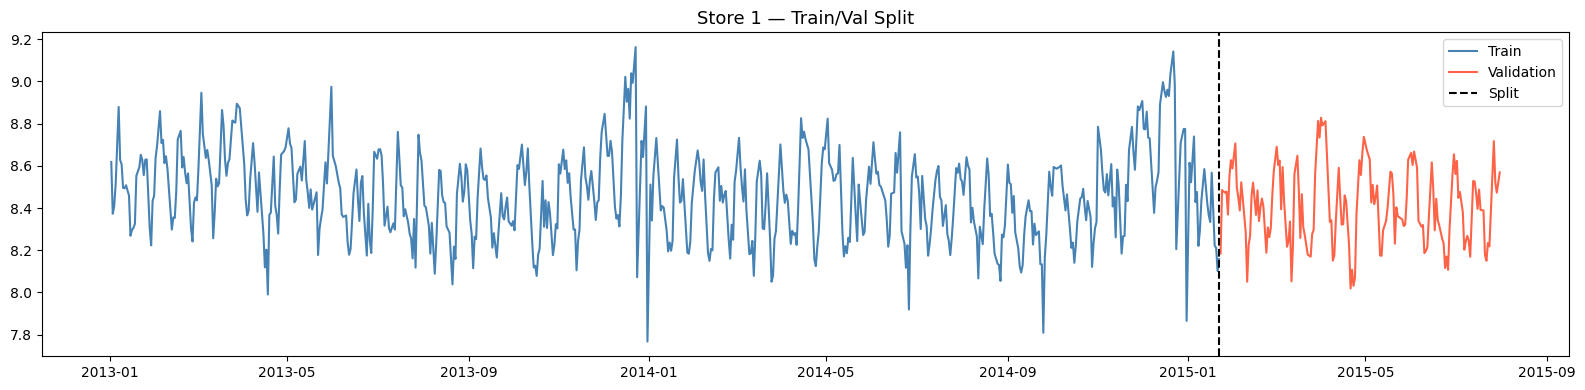

In [2]:
df = pd.read_csv('../data/processed/featured_sales_data.csv', parse_dates=['Date'], low_memory=False)

store_df = (
    df[df['Store'] == STORE_ID].sort_values('Date').set_index('Date').dropna(subset=['Sales_log']))

series    = store_df['Sales_log']
exog_cols = [c for c in EXOG_FEATURES if c in store_df.columns]
exog      = store_df[exog_cols].fillna(0).astype(float)

idx            = int(len(series) * SPLIT_RATIO)
train_y        = series.iloc[:idx]
val_y          = series.iloc[idx:]
train_exog     = exog.iloc[:idx]
val_exog       = exog.iloc[idx:]
actual         = np.expm1(val_y.values)

print(f'Store {STORE_ID} : {len(store_df)} days')
print(f'Exog features  : {len(exog_cols)}')
print(f'Train : {len(train_y)} | Val : {len(val_y)}')

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(train_y, color='steelblue', label='Train')
ax.plot(val_y,   color='tomato',    label='Validation')
ax.axvline(train_y.index[-1], color='black', linestyle='--', label='Split')
ax.set_title(f'Store {STORE_ID} — Train/Val Split')
ax.legend()
plt.tight_layout()
plt.show()

## 3. Stationarity Check — ADF Test

In [3]:
def adf_test(series, label='Series'):
    result = adfuller(series.dropna(), autolag='AIC')
    pval   = result[1]
    status = 'Stationary ✅' if pval < 0.05 else 'Non-stationary ❌'
    print(f'ADF [{label}]  p={pval:.4f}  →  {status}')
    return pval < 0.05

is_stat = adf_test(train_y, 'log(Sales)')
if not is_stat:
    adf_test(train_y.diff().dropna(), '1st Difference')

ADF [log(Sales)]  p=0.0002  →  Stationary ✅


## 4. ACF & PACF Plots

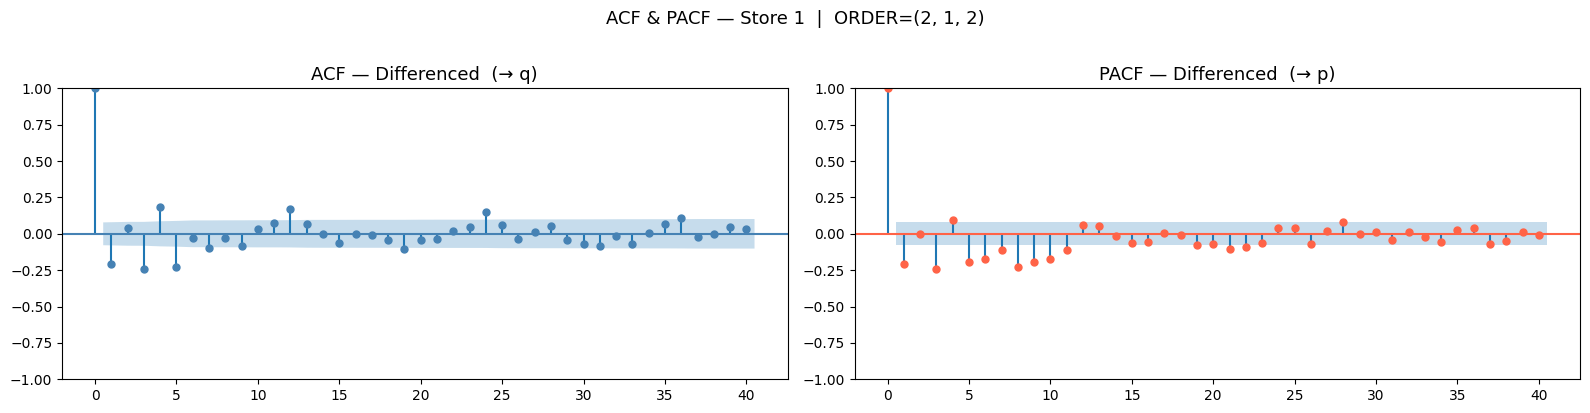

In [4]:
train_diff = train_y.diff().dropna()
fig, axes  = plt.subplots(1, 2, figsize=(16, 4))
plot_acf( train_diff, lags=40, ax=axes[0], color='steelblue')
axes[0].set_title('ACF — Differenced  (→ q)')
plot_pacf(train_diff, lags=40, ax=axes[1], color='tomato', method='ols')
axes[1].set_title('PACF — Differenced  (→ p)')
plt.suptitle(f'ACF & PACF — Store {STORE_ID}  |  ORDER={ORDER}', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/acf_pacf.png', dpi=150)
plt.show()

## 5. Fit Plain ARIMA — Baseline

In [5]:
print(f'Fitting ARIMA{ORDER} (no exog)...')
arima_model = ARIMA(train_y, order=ORDER).fit()
print(f'AIC : {arima_model.aic:.2f}')
print(arima_model.summary())

Fitting ARIMA(2, 1, 2) (no exog)...
AIC : -545.34
                               SARIMAX Results                                
Dep. Variable:              Sales_log   No. Observations:                  624
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 277.671
Date:                Tue, 24 Feb 2026   AIC                           -545.342
Time:                        19:23:18   BIC                           -523.169
Sample:                             0   HQIC                          -536.725
                                - 624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1861      0.070     -2.656      0.008      -0.323      -0.049
ar.L2          0.6315      0.042     15.029      0.000       0.549       0.714
ma

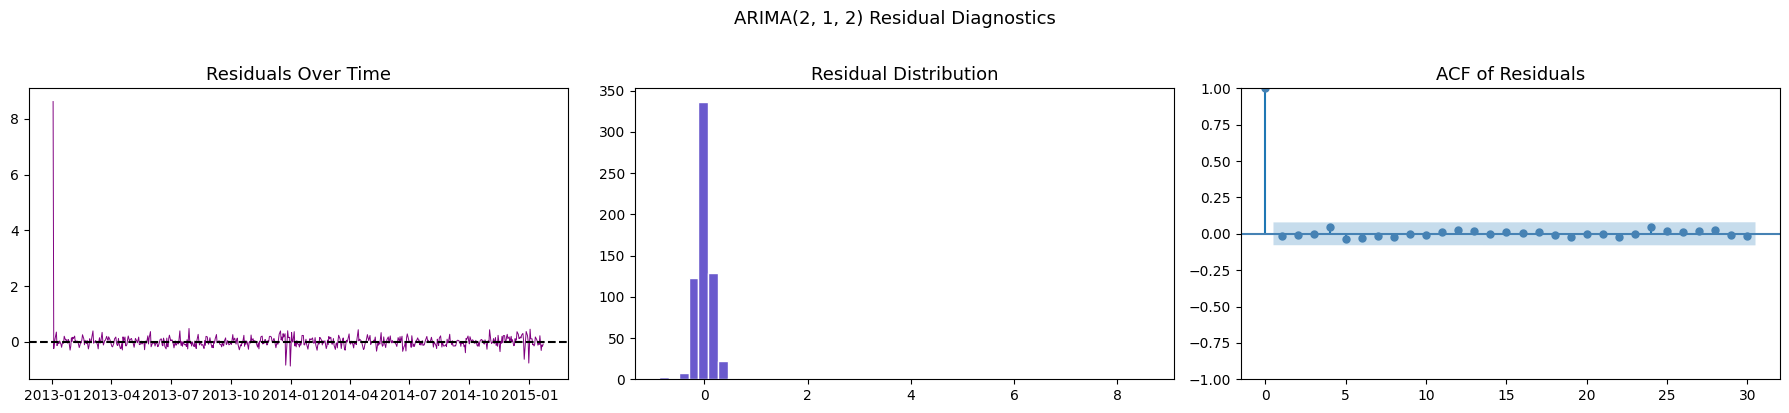

In [6]:
residuals = arima_model.resid
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].plot(residuals, color='purple', linewidth=0.7)
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title('Residuals Over Time')
axes[1].hist(residuals, bins=50, color='slateblue', edgecolor='white')
axes[1].set_title('Residual Distribution')
plot_acf(residuals, lags=30, ax=axes[2], color='steelblue')
axes[2].set_title('ACF of Residuals')
plt.suptitle(f'ARIMA{ORDER} Residual Diagnostics', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 6. Fit SARIMAX with Exogenous Features

Same `(p,d,q)` order — but now learns Promo, holidays, Fourier seasonality.

In [7]:
print(f'Fitting SARIMAX{ORDER} with {len(exog_cols)} exog features...')
sarimax_model = SARIMAX(
    train_y, exog=train_exog,
    order=ORDER,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print(f'ARIMA   AIC : {arima_model.aic:.2f}')
print(f'SARIMAX AIC : {sarimax_model.aic:.2f}  ← lower = better fit')
print(sarimax_model.summary())

Fitting SARIMAX(2, 1, 2) with 16 exog features...
ARIMA   AIC : -545.34
SARIMAX AIC : -790.44  ← lower = better fit
                               SARIMAX Results                                
Dep. Variable:              Sales_log   No. Observations:                  624
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 416.221
Date:                Tue, 24 Feb 2026   AIC                           -790.443
Time:                        19:23:39   BIC                           -697.419
Sample:                             0   HQIC                          -754.284
                                - 624                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Promo                        0.2495      0.020     12.320      0.0

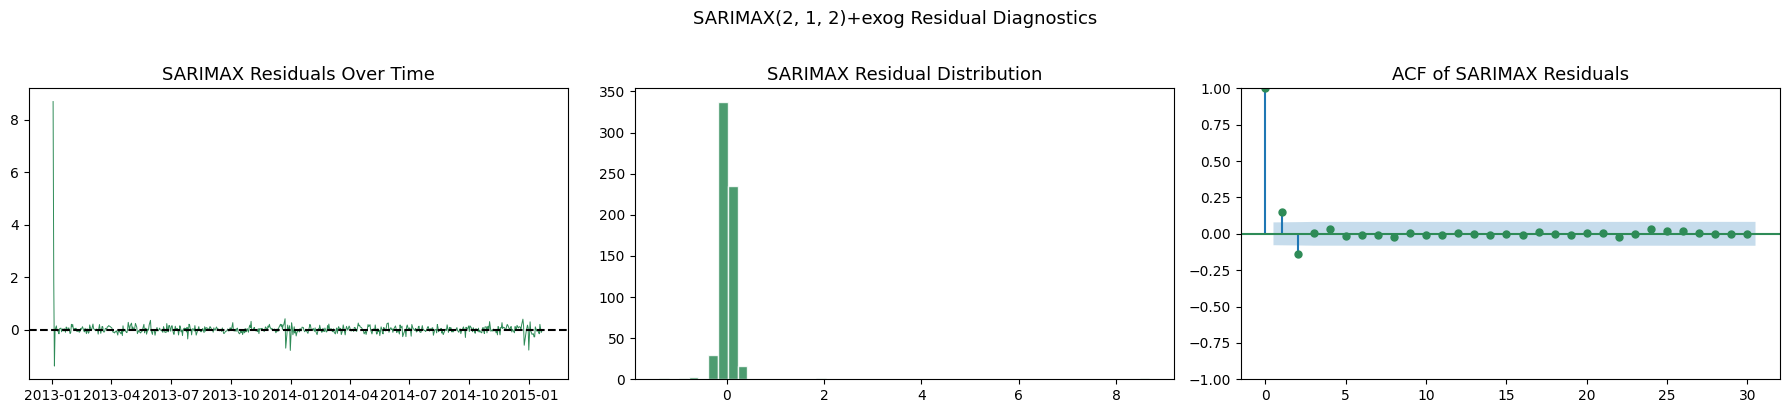

In [8]:
sx_resid = sarimax_model.resid
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].plot(sx_resid, color='seagreen', linewidth=0.7)
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title('SARIMAX Residuals Over Time')
axes[1].hist(sx_resid, bins=50, color='seagreen', edgecolor='white', alpha=0.85)
axes[1].set_title('SARIMAX Residual Distribution')
plot_acf(sx_resid, lags=30, ax=axes[2], color='seagreen')
axes[2].set_title('ACF of SARIMAX Residuals')
plt.suptitle(f'SARIMAX{ORDER}+exog Residual Diagnostics', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 7. Forecast on Validation Set

In [9]:
n            = len(val_y)
arima_pred   = np.expm1(arima_model.forecast(steps=n).values)
sarimax_pred = np.expm1(sarimax_model.forecast(steps=n, exog=val_exog).values)
naive_pred   = np.full(n, np.expm1(train_y.iloc[-1]))
print(f'Forecast horizon : {n} days')

Forecast horizon : 157 days


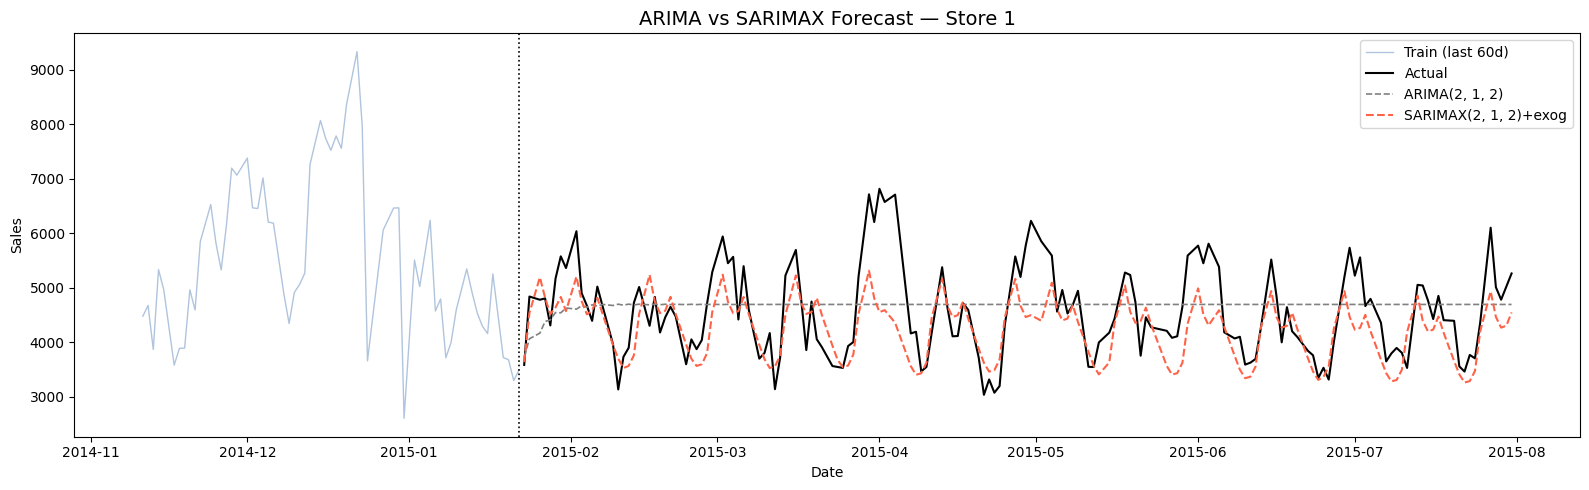

In [10]:
train_tail = np.expm1(train_y.iloc[-60:])
dates      = val_y.index

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(train_tail.index, train_tail.values,
        color='lightsteelblue', linewidth=1, label='Train (last 60d)')
ax.plot(dates, actual,       color='black',   linewidth=1.5, label='Actual')
ax.plot(dates, arima_pred,   color='gray',    linewidth=1.2,
        linestyle='--', label=f'ARIMA{ORDER}')
ax.plot(dates, sarimax_pred, color='tomato',  linewidth=1.5,
        linestyle='--', label=f'SARIMAX{ORDER}+exog')
ax.axvline(train_y.index[-1], color='black', linestyle=':', linewidth=1.2)
ax.set_title(f'ARIMA vs SARIMAX Forecast — Store {STORE_ID}', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/arima_forecast.png', dpi=150)
plt.show()

## 8. Evaluate — MAE, RMSE, MAPE

In [11]:
def evaluate(actual, predicted, label='Model'):
    mae  = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / (actual + 1e-8))) * 100
    print(f'\n── {label} ──')
    print(f'  MAE  : {mae:>10,.2f}')
    print(f'  RMSE : {rmse:>10,.2f}')
    print(f'  MAPE : {mape:>9.2f}%')
    return {'Model': label, 'MAE': round(mae, 2),
            'RMSE': round(rmse, 2), 'MAPE%': round(mape, 2)}

results = [
    evaluate(actual, arima_pred,   f'ARIMA{ORDER}        [no exog]'),
    evaluate(actual, sarimax_pred, f'SARIMAX{ORDER}+exog [improved]'),
    evaluate(actual, naive_pred,    'Naive Baseline'),
]
results_df = pd.DataFrame(results)

mae_gain  = (results[0]['MAE']  - results[1]['MAE'])  / results[0]['MAE']  * 100
rmse_gain = (results[0]['RMSE'] - results[1]['RMSE']) / results[0]['RMSE'] * 100
print(f'\nARIMA → SARIMAX : MAE improved {mae_gain:+.1f}%  |  RMSE improved {rmse_gain:+.1f}%')
print('\n=== Summary ===')
print(results_df.to_string(index=False))


── ARIMA(2, 1, 2)        [no exog] ──
  MAE  :     695.83
  RMSE :     838.37
  MAPE :     16.20%

── SARIMAX(2, 1, 2)+exog [improved] ──
  MAE  :     482.23
  RMSE :     644.25
  MAPE :     10.04%

── Naive Baseline ──
  MAE  :   1,068.36
  RMSE :   1,322.34
  MAPE :     21.39%

ARIMA → SARIMAX : MAE improved +30.7%  |  RMSE improved +23.2%

=== Summary ===
                           Model     MAE    RMSE  MAPE%
 ARIMA(2, 1, 2)        [no exog]  695.83  838.37  16.20
SARIMAX(2, 1, 2)+exog [improved]  482.23  644.25  10.04
                  Naive Baseline 1068.36 1322.34  21.39


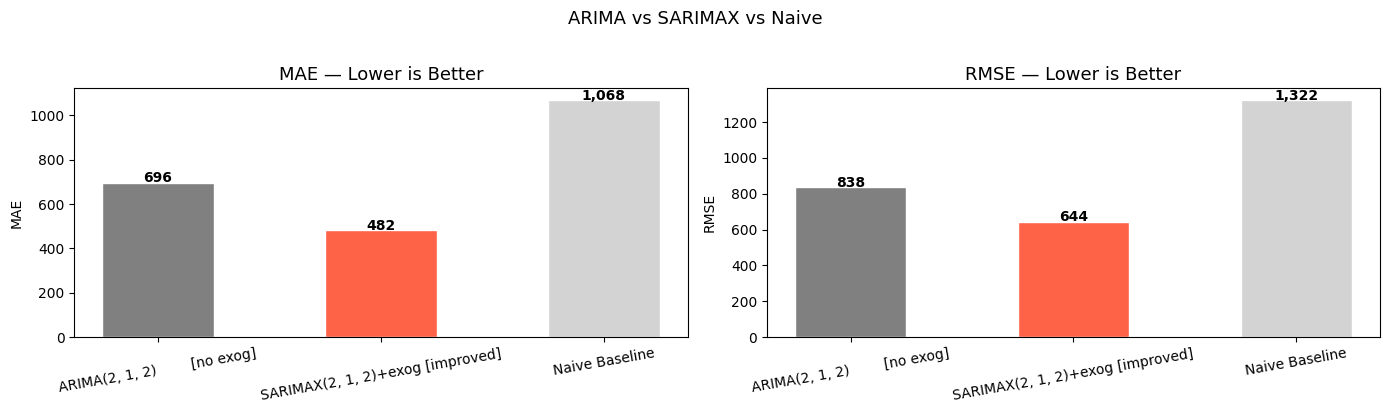

In [12]:
colors = ['gray', 'tomato', 'lightgray']
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for ax, metric in zip(axes, ['MAE', 'RMSE']):
    bars = ax.bar(results_df['Model'], results_df[metric],
                  color=colors, edgecolor='white', width=0.5)
    ax.set_title(f'{metric} — Lower is Better')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=10)
    for bar, val in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{val:,.0f}', ha='center', fontweight='bold', fontsize=10)
plt.suptitle('ARIMA vs SARIMAX vs Naive', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/arima_evaluation.png', dpi=150)
plt.show()

## 9. Save Model & Results

In [13]:
with open('../models/arima_model.pkl', 'wb') as f:
    pickle.dump(sarimax_model, f)
results_df.to_csv('../reports/arima_results.csv', index=False)
print('✅ models/arima_model.pkl        (SARIMAXResultsWrapper)')
print('✅ reports/arima_results.csv')
print()
print('NOTE for notebook 05 — forecast call:')
print('  sarimax_model.forecast(steps=n, exog=val_exog)')

✅ models/arima_model.pkl        (SARIMAXResultsWrapper)
✅ reports/arima_results.csv

NOTE for notebook 05 — forecast call:
  sarimax_model.forecast(steps=n, exog=val_exog)


## 10. Summary

### NOTEBOOK 03 SUMMARY
                                
Store     : 1  |  Order : ARIMA(2, 1, 2)                  
Exog      : 16 features                              

Best model  : SARIMAX(2, 1, 2)+exog [improved]            
MAE         :     482.23                             
RMSE        :     644.25                             

Key insight : SARIMAX >> plain ARIMA because it uses       
Promo, holidays & Fourier signals that ARIMA ignores.      

Next → Notebook 04 : ML Models (RF + XGBoost)   